In [1]:
from envs.KS_environment_jax import KSenv
from envs.KS_solver_jax import KS
import jax.numpy as jnp
import jax
from functools import partial
from ddpg_experiment_v3 import draw_initial_condition, plot_KS_episode
import utils.visualizations as vis
import ml_collections
import matplotlib.pyplot as plt
from utils import covariance_matrix as cov
from pathlib import Path
import yaml
from ddpg import DDPG
import orbax.checkpoint

In [2]:
def generate_episode(config, agent):
    # create environment
    env = KSenv(N=config.env.N,
                nu=config.env.nu,
                actuator_scale=config.env.actuator_scale,
                actuator_locs=config.env.actuator_locs,
                actuator_loss_weight=config.env.actuator_loss_weight,
                burn_in=config.env.burn_in,
                sensor_locs=config.env.sensor_locs,
                target=config.env.target,
                frame_skip=config.env.frame_skip)
    
    env_draw_initial_condition = partial(draw_initial_condition,
                                    std_init=config.enKF.std_init,)
    env_draw_initial_condition = jax.jit(env_draw_initial_condition)

    env_reset = partial(
        KSenv.reset,
        N=env.N,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        initial_amplitude=env.initial_amplitude,
        action_size=env.action_size,
        burn_in=env.burn_in,
        observation_inds=env.observation_inds,
    )
    env_reset = jax.jit(env_reset)
    env_step = partial(
        KSenv.step,
        frame_skip=env.frame_skip,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        target=env.target,
        actuator_loss_weight=env.actuator_loss_weight,
        termination_threshold=env.termination_threshold,
        observation_inds=env.observation_inds,
    )
    env_step = jax.jit(env_step)

    # create a action of zeros to pass
    null_action = jnp.zeros(env.action_size)

    def until_first_observation(true_state, true_obs, observation_starts):
        def body_fun(carry, _):
            true_state, true_obs = carry
            # advance true environment
            action = null_action
            true_state, true_obs, _, _, _, _ = env_step(state=true_state, action=action)
            return (true_state, true_obs), (true_state, true_obs, action)

        (true_state, true_obs), (
            true_state_arr,
            true_obs_arr,
            action_arr,
        ) = jax.lax.scan(
            body_fun, (true_state, true_obs), jnp.arange(observation_starts)
        )
        return (true_state, true_obs, true_state_arr, true_obs_arr, action_arr)
    
    def act_observe_and_forecast(
        true_state, true_obs, params, wait_steps, episode_steps, key_obs
    ):
        def forecast_fun(carry, _):
            true_state, true_obs, action = carry

            # get the next observation and reward with this action
            true_state, true_obs, reward, _, _, _ = env_step(
                state=true_state, action=action
            )

            return (true_state, true_obs, action), (
                true_state,
                true_obs,
                action,
                reward,
            )

        def body_fun(carry, _):
            # observe
            # we got an observation
            # define observation covariance matrix
            true_state, true_obs, key_obs = carry
            obs_cov = cov.get_max(std=config.enKF.std_obs, y=true_obs)

            # add noise on the observation
            key_obs, _ = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            # get action
            action = agent.actor.apply(params, obs)

            # propagate environment with the given action
            (true_state, true_obs, action), (
                true_state_arr,
                true_obs_arr,
                action_arr,
                reward_arr,
            ) = jax.lax.scan(
                forecast_fun, (true_state, true_obs, action), jnp.arange(wait_steps)
            )
            return (true_state, true_obs, key_obs), (
                true_state_arr,
                true_obs_arr,
                obs,
                action_arr,
                reward_arr,
            )

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, key_obs), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(body_fun, (true_state, true_obs, key_obs), jnp.arange(n_loops))
        return (
            true_state,
            true_obs,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        )
    
    until_first_observation = partial(
        until_first_observation, observation_starts=config.enKF.observation_starts
    )
    until_first_observation = jax.jit(until_first_observation)

    act_observe_and_forecast = partial(
        act_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
    act_observe_and_forecast = jax.jit(act_observe_and_forecast)

    def episode(key_env, key_obs, params):
        # reset the environment
        key_env, _, key_init = jax.random.split(key_env, 3)
        init_true_state_mean, _, _ = env_reset(key=key_env)
        init_true_state = env_draw_initial_condition(
            u0=init_true_state_mean, key=key_init
        )
        init_true_obs = init_true_state[env.observation_inds]

        # forecast until first observation
        (
            true_state,
            true_obs,
            true_state_arr0,
            true_obs_arr0,
            action_arr0,
        ) = until_first_observation(true_state=init_true_state, true_obs=init_true_obs)
        (
            true_state,
            true_obs,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = act_observe_and_forecast(
            true_state=true_state,
            true_obs=true_obs,
            params=params,
            key_obs=key_obs,
        )

        true_state_arr = jnp.reshape(
            true_state_arr,
            (
                true_state_arr.shape[0] * true_state_arr.shape[1],
                true_state_arr.shape[2],
            ),
        )
        true_obs_arr = jnp.reshape(
            true_obs_arr,
            (true_obs_arr.shape[0] * true_obs_arr.shape[1], true_obs_arr.shape[2]),
        )
        action_arr = jnp.reshape(
            action_arr,
            (action_arr.shape[0] * action_arr.shape[1], action_arr.shape[2]),
        )
        reward_arr = jnp.reshape(
            reward_arr,
            (reward_arr.shape[0] * reward_arr.shape[1],),
        )
        stack = lambda a, b, c: jnp.vstack((jnp.expand_dims(a, axis=0), b, c))

        return (
            stack(init_true_state, true_state_arr0, true_state_arr),
            stack(init_true_obs, true_obs_arr0, true_obs_arr),
            obs_arr,
            stack(null_action, action_arr0, action_arr),
            reward_arr,
            key_env,
            key_obs,
        )
    return episode

In [3]:
def load_config(experiment_path):
    with open(experiment_path / "config.yml", "r") as file:
        config = yaml.unsafe_load(file)
        return config

# load config from experiment
# experiment_path = Path('local_results/KS/run_20241029_152902') # N = 64, regular
experiment_path = Path('local_results/KS/run_20241030_172457') # N = 16, regular

config = load_config(experiment_path)
config.env.N = 64
# config.episode_steps = 1000

# create environment
env = KSenv(**config.env)
# create agent
agent = DDPG(config, env)

# load model weights
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
weights_path = experiment_path / 'final_model'
params_dict = orbax_checkpointer.restore(weights_path.absolute())
params = params_dict["actor"]["target_params"]

In [4]:
key = jax.random.PRNGKey(3)
key, key_env, key_obs, key_action = jax.random.split(key, 4) 
episode = generate_episode(config, agent)

In [5]:
(
    true_state_arr,
    true_obs_arr,
    obs_arr,
    action_arr,
    reward_arr,
    key_env,
    key_obs,
) =  episode(key_env, key_obs, params)

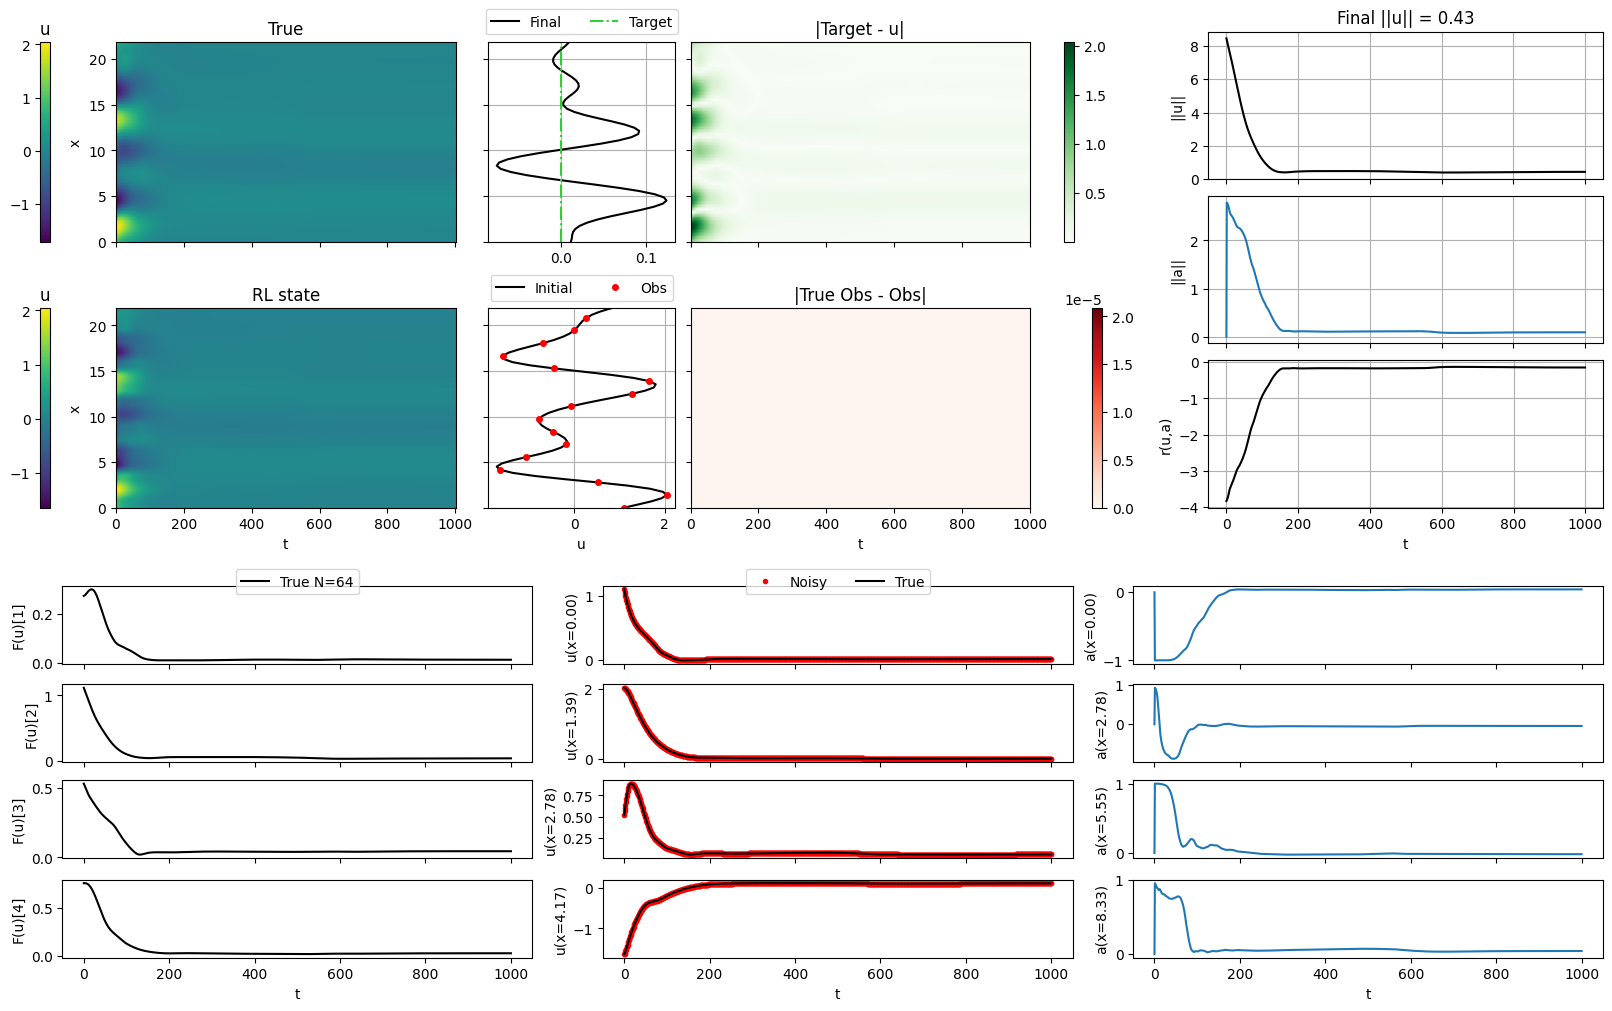

In [6]:
fig = plot_KS_episode(
    env,
    true_state_arr,
    true_obs_arr,
    obs_arr,
    action_arr,
    reward_arr,
    config.enKF.wait_steps,
    config.enKF.observation_starts,
)

In [8]:
from utils import file_processing as fp
data_dict = {
             'true_state':true_state_arr,  
             'action': action_arr
            }
fp.pickle_file('controlled_traj_data.pickle',data_dict)

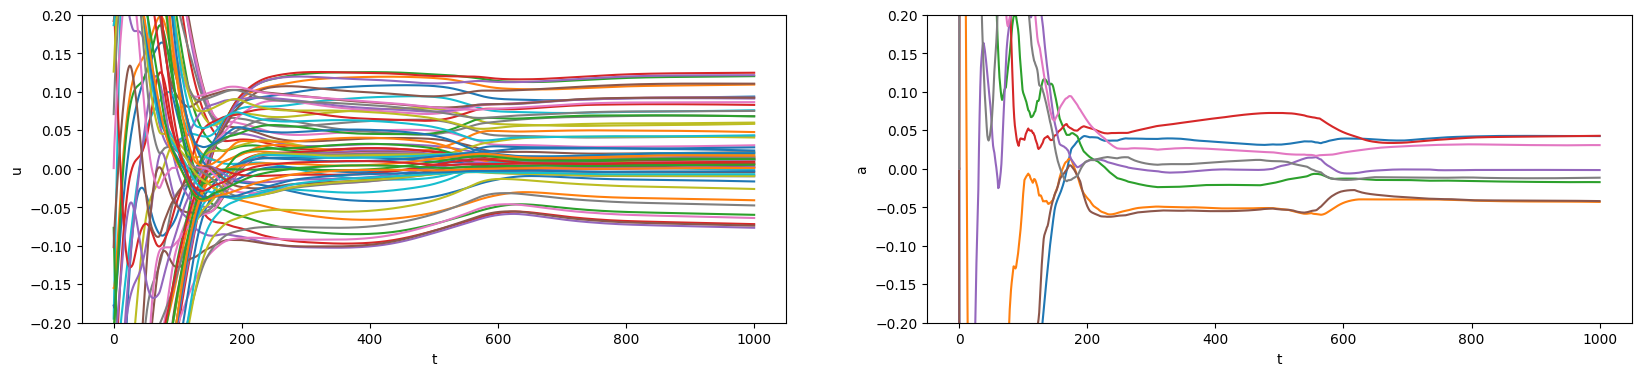

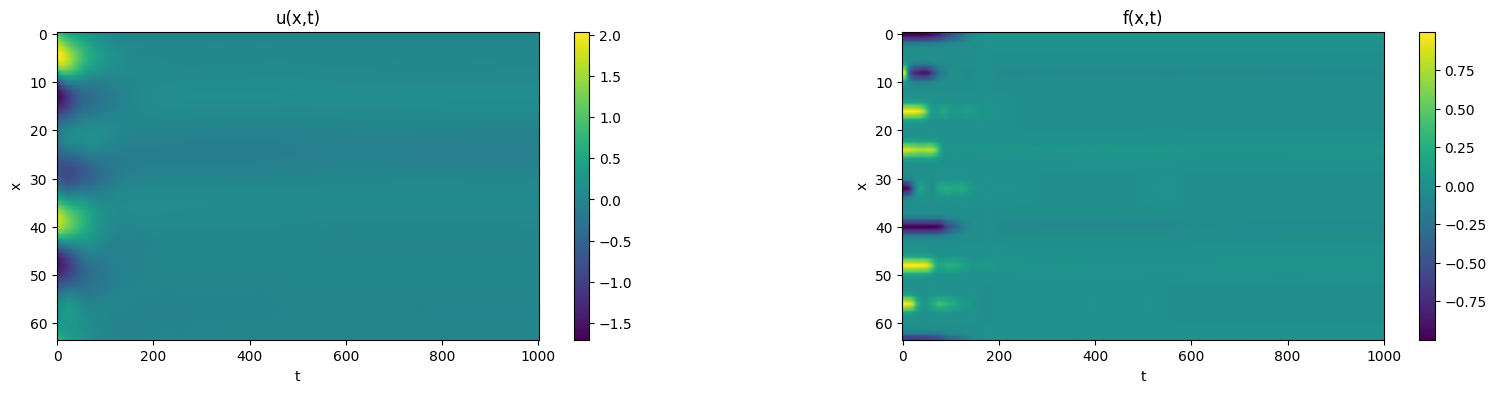

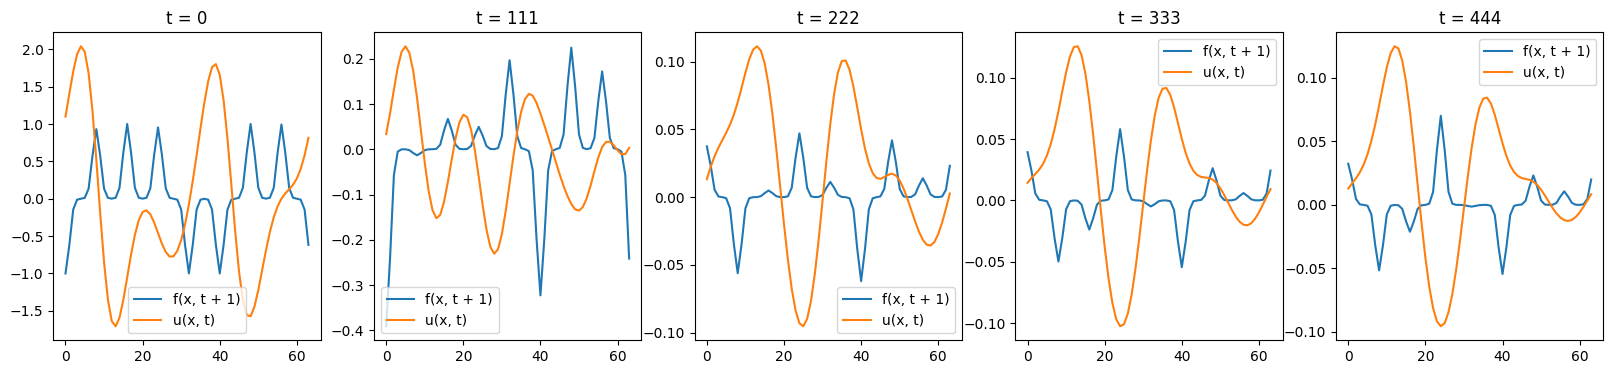

In [145]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(true_state_arr)
plt.ylim([-0.2,0.2])
plt.ylabel('u')
plt.xlabel('t')
plt.subplot(1,2,2)
plt.plot(action_arr)
plt.ylim([-0.2,0.2])
plt.ylabel('a')
plt.xlabel('t')

f = (env.ks_solver.B @ action_arr.T).T
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.imshow(true_state_arr.T, aspect = 10)
plt.ylabel('x')
plt.xlabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(f.T, aspect = 10)
plt.ylabel('x')
plt.xlabel('t')
plt.title('f(x,t)')
plt.colorbar()

plt.figure(figsize=(20,4))
n_idxs = 5
idxs = jnp.linspace(0,len(f),10)
for i in range(n_idxs):
    idx = int(idxs[i])
    plt.subplot(1, n_idxs, i+1)
    plt.plot(f[idx+1], label='f(x, t + 1)')
    plt.plot(true_state_arr[idx],label='u(x, t)')
    plt.title(f't = {idx}')
    plt.legend()

In [73]:
actor_params = params_dict["actor"]["target_params"]
critic_params = params_dict["critic"]["target_params"]

In [74]:
start_idx = 0
state = true_state_arr[start_idx]
next_state = true_state_arr[start_idx+1]

action = agent.actor.apply(actor_params, state)
next_action = agent.actor.apply(actor_params, next_state)

value = agent.critic.apply(critic_params, state, action)
next_value = agent.critic.apply(critic_params, next_state, next_action)

discounted_value = 0
for k, reward in enumerate(reward_arr[start_idx:]):
    discounted_value += reward * (agent.gamma) ** k

In [75]:
bellman_value = reward_arr[start_idx] + agent.gamma * next_value
print(f'Value = {value}, Bellman Value = {bellman_value}')
print(f'True discounted value = {discounted_value}')

Value = [-214.5023829], Bellman Value = [-215.23304196]
True discounted value = -240.65917612195315


In [76]:
key, select_key = jax.random.split(key, 2) 
indices = jax.random.randint(select_key, (256,), minval=0, maxval=len(true_state_arr))
sampled_states = true_state_arr[indices, :]
sampled_actions = agent.actor.apply(actor_params, sampled_states)
sampled_values = agent.critic.apply(critic_params, sampled_states, sampled_actions)

In [77]:
jnp.mean(sampled_values)

Array(-44.27517221, dtype=float64)